# Churn Prediction Model

This notebook implements a churn prediction model for a music streaming service.

## Day 1: Data Pipeline & Feature Engineering Foundation

**Goal**: Transform event logs into user-level features for prediction.

## Step 1.1: Load Data and Create Labels

In [32]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

# Load data
print("Loading data...")
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

print(f"Train: {train.shape[0]:,} rows")
print(f"Test: {test.shape[0]:,} rows")

Loading data...
Train: 17,499,636 rows
Test: 4,393,179 rows


In [33]:
# Create user-level churn labels
churned_users = train[train['page'] == 'Cancellation Confirmation']['userId'].unique()
all_users = train['userId'].unique()

print(f"Total users: {len(all_users):,}")
print(f"Churned users: {len(churned_users):,}")
print(f"Churn rate: {len(churned_users)/len(all_users):.2%}")

# Get churn timestamps for temporal slicing later
churn_times = train[train['page'] == 'Cancellation Confirmation'].groupby('userId')['time'].first()
print(f"\nChurn times recorded for {len(churn_times):,} users")

Total users: 19,140
Churned users: 4,271
Churn rate: 22.31%

Churn times recorded for 4,271 users


## Step 1.2: Vectorized Feature Engineering

Using `groupby` and vectorized pandas operations for ~100x speedup over row-by-row processing.

Feature categories:
- **Engagement**: total events, songs, sessions
- **Behavioral ratios**: thumbs up/down per song, error rate
- **Temporal**: days active, recency, activity trend
- **Subscription**: paid/free status, level changes, downgrade/upgrade events
- **Content diversity**: unique songs/artists, listen time

In [34]:
def create_user_features_vectorized(df, churn_times_series=None, cancel_cutoff_hours=12):
    """
    Vectorized feature engineering using groupby operations.
    ~100x faster than row-by-row processing.

    Parameters:
    - df: DataFrame with events
    - churn_times_series: Series with userId as index, churn time as value (for Cancel page handling)
    - cancel_cutoff_hours: Hours before churn to exclude Cancel page visits (default: 12)

    Returns:
    - DataFrame with one row per user
    """
    print("Computing basic aggregations...")

    # ===== BASIC AGGREGATIONS =====
    basic_agg = df.groupby('userId').agg(
        total_events=('page', 'count'),
        total_sessions=('sessionId', 'nunique'),
        time_min=('time', 'min'),
        time_max=('time', 'max'),
        registration=('registration', 'first'),
        gender=('gender', 'first'),
        location=('location', 'first'),
        level_last=('level', 'last'),
    )

    # ===== PAGE COUNTS (using crosstab for efficiency) =====
    print("Computing page counts...")
    important_pages = ['NextSong', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist',
                       'Add Friend', 'Downgrade', 'Upgrade', 'Error', 'Help',
                       'Home', 'Settings', 'Roll Advert', 'Logout']

    # Filter to important pages only, then crosstab
    page_df = df[df['page'].isin(important_pages)][['userId', 'page']]
    page_counts = pd.crosstab(page_df['userId'], page_df['page'])

    # Ensure all important pages exist as columns
    for page in important_pages:
        if page not in page_counts.columns:
            page_counts[page] = 0

    # Rename columns
    page_counts.columns = [f'page_{col.lower().replace(" ", "_")}' for col in page_counts.columns]

    # ===== SESSION STATISTICS =====
    print("Computing session statistics...")
    session_sizes = df.groupby(['userId', 'sessionId']).size().reset_index(name='session_length')
    session_stats = session_sizes.groupby('userId')['session_length'].agg(
        avg_session_length='mean',
        max_session_length='max',
        std_session_length='std'
    ).fillna(0)

    # ===== SONG-RELATED FEATURES =====
    print("Computing song features...")
    songs_df = df[df['page'] == 'NextSong']

    song_agg = songs_df.groupby('userId').agg(
        total_songs=('page', 'count'),
        unique_songs=('song', 'nunique'),
        unique_artists=('artist', 'nunique'),
        avg_song_length=('length', lambda x: x.clip(upper=1200).mean()),
        total_listen_time=('length', lambda x: x.clip(upper=1200).sum()),
        std_song_length=('length', lambda x: x.clip(upper=1200).std()),
    ).fillna(0)

    # ===== LEVEL CHANGES =====
    print("Computing subscription features...")
    df_sorted = df.sort_values(['userId', 'time'])
    df_sorted['level_changed'] = (df_sorted['level'] != df_sorted.groupby('userId')['level'].shift()).astype(int)
    level_changes = df_sorted.groupby('userId')['level_changed'].sum() - 1  # subtract 1 for first row
    level_changes = level_changes.clip(lower=0)

    # Paid events ratio
    df_sorted['is_paid_event'] = (df_sorted['level'] == 'paid').astype(int)
    paid_ratio = df_sorted.groupby('userId')['is_paid_event'].mean()

    # ===== ACTIVITY TREND =====
    print("Computing temporal features...")
    def compute_activity_trend(group):
        if len(group) <= 1:
            return 0
        mid_time = group['time'].min() + (group['time'].max() - group['time'].min()) / 2
        first_half = (group['time'] <= mid_time).sum()
        second_half = (group['time'] > mid_time).sum()
        return (second_half - first_half) / max(first_half, 1)

    activity_trend = df.groupby('userId').apply(compute_activity_trend, include_groups=False)

    # ===== CANCEL PAGE VISITS (with parameterized exclusion) =====
    print(f"Computing cancel page visits (excluding within {cancel_cutoff_hours}h of churn)...")
    cancel_df = df[df['page'] == 'Cancel'][['userId', 'time']].copy()

    if churn_times_series is not None and len(cancel_df) > 0:
        # Merge churn times
        cancel_df = cancel_df.merge(
            churn_times_series.rename('churn_time').reset_index(),
            on='userId',
            how='left'
        )
        # Count only cancels > cutoff hours before churn (or all if no churn)
        cancel_df['is_safe'] = (
            cancel_df['churn_time'].isna() |
            (cancel_df['time'] < cancel_df['churn_time'] - pd.Timedelta(hours=cancel_cutoff_hours))
        )
        cancel_page_visits = cancel_df[cancel_df['is_safe']].groupby('userId').size()
    else:
        cancel_page_visits = cancel_df.groupby('userId').size()

    # ===== COMBINE ALL FEATURES =====
    print("Combining features...")
    features = basic_agg.copy()

    # Join page counts
    features = features.join(page_counts, how='left').fillna(0)

    # Join session stats
    features = features.join(session_stats, how='left').fillna(0)

    # Join song features
    features = features.join(song_agg, how='left').fillna(0)

    # Add level changes and paid ratio
    features['level_changes'] = level_changes
    features['paid_ratio'] = paid_ratio

    # Add activity trend
    features['activity_trend'] = activity_trend

    # Add cancel page visits
    features['cancel_page_visits'] = cancel_page_visits.reindex(features.index).fillna(0).astype(int)

    # ===== COMPUTE DERIVED FEATURES =====
    print("Computing derived features...")

    # Temporal features
    features['days_active'] = (features['time_max'] - features['time_min']).dt.days + 1
    features['days_since_registration'] = (features['time_max'] - features['registration']).dt.days
    features['events_per_day'] = features['total_events'] / features['days_active'].clip(lower=1)
    features['songs_per_day'] = features['total_songs'] / features['days_active'].clip(lower=1)

    # Subscription features
    features['is_paid'] = (features['level_last'] == 'paid').astype(int)
    features['has_downgrade'] = (features['page_downgrade'] > 0).astype(int)
    features['has_upgrade'] = (features['page_upgrade'] > 0).astype(int)

    # Behavioral ratios
    features['thumbs_up_ratio'] = features['page_thumbs_up'] / features['total_songs'].clip(lower=1)
    features['thumbs_down_ratio'] = features['page_thumbs_down'] / features['total_songs'].clip(lower=1)
    features['playlist_add_ratio'] = features['page_add_to_playlist'] / features['total_songs'].clip(lower=1)
    features['error_rate'] = features['page_error'] / features['total_events'].clip(lower=1)
    features['ad_ratio'] = features['page_roll_advert'] / features['total_songs'].clip(lower=1)

    # Song repeat ratio
    features['song_repeat_ratio'] = features['total_songs'] / features['unique_songs'].clip(lower=1)

    # Fix ratios for users with 0 songs
    zero_songs = features['total_songs'] == 0
    ratio_cols = ['thumbs_up_ratio', 'thumbs_down_ratio', 'playlist_add_ratio', 'ad_ratio', 'song_repeat_ratio']
    features.loc[zero_songs, ratio_cols] = 0

    # ===== EXTRACT STATE FROM LOCATION =====
    def extract_state(loc):
        if pd.isna(loc) or loc == 'Unknown':
            return 'Unknown'
        if ',' in str(loc):
            return str(loc).split(',')[-1].strip()[:2]
        return 'Unknown'

    features['state'] = features['location'].apply(extract_state)

    # Fix gender - ensure it's always a string (handles mixed types from NaN)
    features['gender'] = features['gender'].fillna('Unknown').astype(str)

    # ===== CLEANUP =====
    # Drop intermediate columns
    features = features.drop(columns=['time_min', 'time_max', 'registration', 'location', 'level_last'])

    # Reset index to make userId a column
    features = features.reset_index()

    print(f"Done! Created {len(features)} user feature rows with {len(features.columns)-1} features")
    return features

## Step 1.3: Create Training Dataset

In [35]:
# Create features for all training users using vectorized operations
print("Creating features for training users...")
print(f"Processing {len(all_users):,} users from {len(train):,} events\n")

import time
start_time = time.time()

train_features = create_user_features_vectorized(train, churn_times_series=churn_times)

elapsed = time.time() - start_time
print(f"\nCompleted in {elapsed:.1f} seconds")

# Add churn labels
churned_set = set(churned_users)
train_features['churn'] = train_features['userId'].apply(lambda x: 1 if x in churned_set else 0)

print(f"\nTraining set shape: {train_features.shape}")
print(f"Churn distribution:\n{train_features['churn'].value_counts()}")

Creating features for training users...
Processing 19,140 users from 17,499,636 events

Computing basic aggregations...
Computing page counts...
Computing session statistics...
Computing song features...
Computing subscription features...
Computing temporal features...
Computing cancel page visits (excluding within 12h of churn)...
Combining features...
Computing derived features...
Done! Created 19140 user feature rows with 43 features

Completed in 32.4 seconds

Training set shape: (19140, 45)
Churn distribution:
churn
0    14869
1     4271
Name: count, dtype: int64


In [36]:
# Verify feature quality
print("Feature columns:")
print(train_features.columns.tolist())
print(f"\nTotal features: {len(train_features.columns) - 2}")  # excluding userId and churn

# Check for any missing values
missing = train_features.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values:")
    print(missing[missing > 0])
else:
    print("\nNo missing values in features!")

Feature columns:
['userId', 'total_events', 'total_sessions', 'gender', 'page_add_friend', 'page_add_to_playlist', 'page_downgrade', 'page_error', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_roll_advert', 'page_settings', 'page_thumbs_down', 'page_thumbs_up', 'page_upgrade', 'avg_session_length', 'max_session_length', 'std_session_length', 'total_songs', 'unique_songs', 'unique_artists', 'avg_song_length', 'total_listen_time', 'std_song_length', 'level_changes', 'paid_ratio', 'activity_trend', 'cancel_page_visits', 'days_active', 'days_since_registration', 'events_per_day', 'songs_per_day', 'is_paid', 'has_downgrade', 'has_upgrade', 'thumbs_up_ratio', 'thumbs_down_ratio', 'playlist_add_ratio', 'error_rate', 'ad_ratio', 'song_repeat_ratio', 'state', 'churn']

Total features: 43

No missing values in features!


In [37]:
# Basic statistics for key features
key_features = ['total_events', 'total_songs', 'total_sessions', 'days_active',
                'thumbs_down_ratio', 'error_rate', 'has_downgrade', 'activity_trend']

print("Key feature statistics:")
train_features[key_features].describe()

Key feature statistics:


,total_events,total_songs,total_sessions,days_active,thumbs_down_ratio,error_rate,has_downgrade,activity_trend
count,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000,19140.000000
mean,914.296552,746.678840,10.885998,32.147910,0.013100,0.001019,0.636677,2.149112
std,1079.652218,898.682491,10.654959,15.689274,0.014867,0.002589,0.480969,16.869290
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.998270
25%,202.000000,155.000000,4.000000,21.000000,0.006939,0.000000,0.000000,-0.370469
50%,537.500000,428.000000,8.000000,37.000000,0.010383,0.000000,1.000000,0.111111
75%,1213.000000,991.000000,14.000000,45.000000,0.015185,0.001351,1.000000,1.136364
max,10998.000000,9248.000000,116.000000,50.000000,0.500000,0.111111,1.000000,934.000000


In [38]:
# Save training features
train_features.to_parquet('train_features.parquet', index=False)
print("Training features saved to train_features.parquet")

Training features saved to train_features.parquet


## Step 1.4: Create Test Dataset

In [39]:
# Create features for test users using vectorized operations
test_users = test['userId'].unique()
print(f"Creating features for {len(test_users):,} test users from {len(test):,} events\n")

start_time = time.time()

test_features = create_user_features_vectorized(test, churn_times_series=None)

elapsed = time.time() - start_time
print(f"\nCompleted in {elapsed:.1f} seconds")
print(f"Test set shape: {test_features.shape}")

Creating features for 2,904 test users from 4,393,179 events

Computing basic aggregations...
Computing page counts...
Computing session statistics...
Computing song features...
Computing subscription features...
Computing temporal features...
Computing cancel page visits (excluding within 12h of churn)...
Combining features...
Computing derived features...
Done! Created 2904 user feature rows with 43 features

Completed in 6.4 seconds
Test set shape: (2904, 44)


In [40]:
# Verify test features match train features (excluding churn column)
train_cols = set(train_features.columns) - {'churn'}
test_cols = set(test_features.columns)

if train_cols == test_cols:
    print("Feature columns match between train and test!")
else:
    print("Column differences:")
    print(f"  In train only: {train_cols - test_cols}")
    print(f"  In test only: {test_cols - train_cols}")

# Check for missing values in test
missing_test = test_features.isnull().sum()
if missing_test.sum() > 0:
    print("\nMissing values in test:")
    print(missing_test[missing_test > 0])
else:
    print("\nNo missing values in test features!")

Feature columns match between train and test!

No missing values in test features!


In [41]:
# Save test features
test_features.to_parquet('test_features.parquet', index=False)
print("Test features saved to test_features.parquet")

Test features saved to test_features.parquet


## Day 1 Summary

### Completed:
- Loaded train (17.5M events) and test (4.4M events) data
- Created user-level churn labels (22% churn rate)
- Built feature engineering function with 35+ features
- Created training features for 19,140 users
- Created test features for 2,904 users
- Saved features as parquet files

### Feature Categories:
| Category | Features |
|----------|----------|
| Engagement | total_events, total_songs, total_sessions, avg/max/std_session_length |
| Page counts | page_nextsong, page_thumbs_up/down, page_downgrade, etc. |
| Behavioral ratios | thumbs_up/down_ratio, playlist_add_ratio, error_rate, ad_ratio |
| Temporal | days_active, days_since_registration, events_per_day, activity_trend |
| Subscription | is_paid, level_changes, has_downgrade, has_upgrade, paid_ratio |
| Content | unique_songs/artists, avg_song_length, total_listen_time, song_repeat_ratio |
| Demographics | gender, state |

In [42]:
# Final summary
print("="*50)
print("DAY 1 COMPLETE")
print("="*50)
print(f"\nTraining set: {train_features.shape[0]:,} users, {train_features.shape[1]-2} features")
print(f"Test set: {test_features.shape[0]:,} users, {test_features.shape[1]-1} features")
print(f"\nChurn rate: {train_features['churn'].mean():.2%}")
print(f"\nFiles created:")
print("  - train_features.parquet")
print("  - test_features.parquet")

DAY 1 COMPLETE

Training set: 19,140 users, 43 features
Test set: 2,904 users, 43 features

Churn rate: 22.31%

Files created:
  - train_features.parquet
  - test_features.parquet


---

## Day 2: Baseline Models & Validation Strategy

**Goal**: Train baseline models, establish validation approach, analyze feature importance.

### Step 2.1: Load Features and Prepare Data

In [43]:
# Day 2 imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Load features (can start fresh from here if needed)
train_df = pd.read_parquet('train_features.parquet')
print(f"Loaded training features: {train_df.shape}")
print(f"Churn distribution:\n{train_df['churn'].value_counts()}")

Loaded training features: (19140, 45)
Churn distribution:
churn
0    14869
1     4271
Name: count, dtype: int64


In [44]:
# Separate features and target
X = train_df.drop(['userId', 'churn'], axis=1)
y = train_df['churn']

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nFeature types:")
print(X.dtypes.value_counts())

Features shape: (19140, 43)
Target distribution: {0: 14869, 1: 4271}

Feature types:
int64      23
float64    18
object      2
Name: count, dtype: int64


In [45]:
# Encode categorical features
# Gender: M, F, Unknown
le_gender = LabelEncoder()
X['gender'] = le_gender.fit_transform(X['gender'])
print(f"Gender classes: {list(le_gender.classes_)}")

# State: 50+ unique states
le_state = LabelEncoder()
X['state'] = le_state.fit_transform(X['state'])
print(f"State classes: {len(le_state.classes_)} unique states")

# Store encoders for later use with test data
print(f"\nAll features are now numeric: {X.dtypes.value_counts().to_dict()}")

Gender classes: ['F', 'M']
State classes: 51 unique states

All features are now numeric: {dtype('int64'): 25, dtype('float64'): 18}


In [46]:
# Create stratified train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"\nTrain churn rate: {y_train.mean():.2%}")
print(f"Val churn rate: {y_val.mean():.2%}")

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nFeatures scaled with StandardScaler")

Train set: 15,312 samples
Validation set: 3,828 samples

Train churn rate: 22.32%
Val churn rate: 22.31%

Features scaled with StandardScaler


### Step 2.2: Baseline Model - Logistic Regression

In [47]:
# Train Logistic Regression with balanced class weights
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_lr = lr.predict(X_val_scaled)
y_pred_lr_prob = lr.predict_proba(X_val_scaled)[:, 1]

print("="*50)
print("LOGISTIC REGRESSION RESULTS")
print("="*50)
print(f"\nAccuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred_lr, target_names=['Not Churned', 'Churned']))

LOGISTIC REGRESSION RESULTS

Accuracy: 0.8130

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.93      0.82      0.87      2974
     Churned       0.56      0.80      0.66       854

    accuracy                           0.81      3828
   macro avg       0.75      0.81      0.76      3828
weighted avg       0.85      0.81      0.82      3828



In [48]:
# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_val, y_pred_lr)
print("Confusion Matrix (Logistic Regression):")
print(f"                 Predicted")
print(f"                 No Churn  Churned")
print(f"Actual No Churn   {cm_lr[0,0]:5d}    {cm_lr[0,1]:5d}")
print(f"Actual Churned    {cm_lr[1,0]:5d}    {cm_lr[1,1]:5d}")

Confusion Matrix (Logistic Regression):
                 Predicted
                 No Churn  Churned
Actual No Churn    2429      545
Actual Churned      171      683


In [49]:
# Feature importance for Logistic Regression (absolute coefficients)
lr_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_[0],
    'abs_importance': np.abs(lr.coef_[0])
}).sort_values('abs_importance', ascending=False)

print("Top 15 Features (Logistic Regression):")
print(lr_importance[['feature', 'coefficient']].head(15).to_string(index=False))

Top 15 Features (Logistic Regression):
           feature  coefficient
    unique_artists     4.119405
       days_active    -1.892103
      total_events     1.885376
     page_nextsong    -1.511879
       total_songs    -1.511879
      unique_songs    -1.294645
 total_listen_time    -1.008247
    events_per_day     0.756516
avg_session_length    -0.710113
     has_downgrade     0.695490
          ad_ratio     0.654700
    page_downgrade     0.560229
std_session_length     0.516873
  page_roll_advert     0.512167
    page_thumbs_up    -0.450061


### Step 2.3: Baseline Model - Random Forest

In [50]:
# Train Random Forest (no scaling needed for tree models)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_rf = rf.predict(X_val)
y_pred_rf_prob = rf.predict_proba(X_val)[:, 1]

print("="*50)
print("RANDOM FOREST RESULTS")
print("="*50)
print(f"\nAccuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred_rf, target_names=['Not Churned', 'Churned']))

RANDOM FOREST RESULTS

Accuracy: 0.8710

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.92      0.91      0.92      2974
     Churned       0.71      0.72      0.71       854

    accuracy                           0.87      3828
   macro avg       0.81      0.82      0.81      3828
weighted avg       0.87      0.87      0.87      3828



In [51]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_val, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(f"                 Predicted")
print(f"                 No Churn  Churned")
print(f"Actual No Churn   {cm_rf[0,0]:5d}    {cm_rf[0,1]:5d}")
print(f"Actual Churned    {cm_rf[1,0]:5d}    {cm_rf[1,1]:5d}")

Confusion Matrix (Random Forest):
                 Predicted
                 No Churn  Churned
Actual No Churn    2720      254
Actual Churned      240      614


In [52]:
# Feature importance for Random Forest
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features (Random Forest):")
print(rf_importance.head(15).to_string(index=False))

Top 15 Features (Random Forest):
                feature  importance
            days_active    0.252302
         events_per_day    0.102342
          songs_per_day    0.099815
days_since_registration    0.077013
               ad_ratio    0.037695
     avg_session_length    0.026338
        thumbs_up_ratio    0.025622
      thumbs_down_ratio    0.023152
      total_listen_time    0.019977
       page_roll_advert    0.019928
         page_thumbs_up    0.017524
         total_sessions    0.016857
           total_events    0.016756
     std_session_length    0.016393
           unique_songs    0.015646


### Step 2.4: Cross-Validation

In [53]:
# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running 5-fold stratified cross-validation...")
print("="*50)

# Logistic Regression CV (needs scaled features)
# Create a pipeline for proper CV with scaling
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

lr_cv_scores = cross_val_score(lr_pipeline, X, y, cv=cv, scoring='accuracy')
print(f"\nLogistic Regression CV Accuracy: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std()*2:.4f})")
print(f"  Fold scores: {[f'{s:.4f}' for s in lr_cv_scores]}")

# Random Forest CV (no scaling needed)
rf_cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print(f"\nRandom Forest CV Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std()*2:.4f})")
print(f"  Fold scores: {[f'{s:.4f}' for s in rf_cv_scores]}")

Running 5-fold stratified cross-validation...

Logistic Regression CV Accuracy: 0.8182 (+/- 0.0115)
  Fold scores: ['0.8197', '0.8069', '0.8205', '0.8203', '0.8234']

Random Forest CV Accuracy: 0.8707 (+/- 0.0047)
  Fold scores: ['0.8717', '0.8678', '0.8681', '0.8720', '0.8738']


### Step 2.5: Feature Importance Analysis

In [54]:
# Compare feature importance between models
import matplotlib.pyplot as plt

# Merge importance rankings
importance_comparison = lr_importance[['feature', 'abs_importance']].rename(
    columns={'abs_importance': 'lr_importance'}
).merge(
    rf_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    on='feature'
)

# Normalize to 0-1 scale for comparison
importance_comparison['lr_normalized'] = importance_comparison['lr_importance'] / importance_comparison['lr_importance'].max()
importance_comparison['rf_normalized'] = importance_comparison['rf_importance'] / importance_comparison['rf_importance'].max()
importance_comparison['avg_importance'] = (importance_comparison['lr_normalized'] + importance_comparison['rf_normalized']) / 2
importance_comparison = importance_comparison.sort_values('avg_importance', ascending=False)

print("Top 15 Features (Combined Ranking):")
print(importance_comparison[['feature', 'lr_normalized', 'rf_normalized', 'avg_importance']].head(15).to_string(index=False))

Top 15 Features (Combined Ranking):
                feature  lr_normalized  rf_normalized  avg_importance
            days_active       0.459315       1.000000        0.729657
         unique_artists       1.000000       0.052925        0.526462
         events_per_day       0.183647       0.405633        0.294640
           total_events       0.457682       0.066413        0.262047
          songs_per_day       0.097633       0.395618        0.246625
            total_songs       0.367014       0.061813        0.214413
          page_nextsong       0.367014       0.059353        0.213184
           unique_songs       0.314280       0.062014        0.188147
days_since_registration       0.038978       0.305240        0.172109
      total_listen_time       0.244755       0.079178        0.161967
               ad_ratio       0.158931       0.149404        0.154167
     avg_session_length       0.172382       0.104392        0.138387
          has_downgrade       0.168833       0.041954 

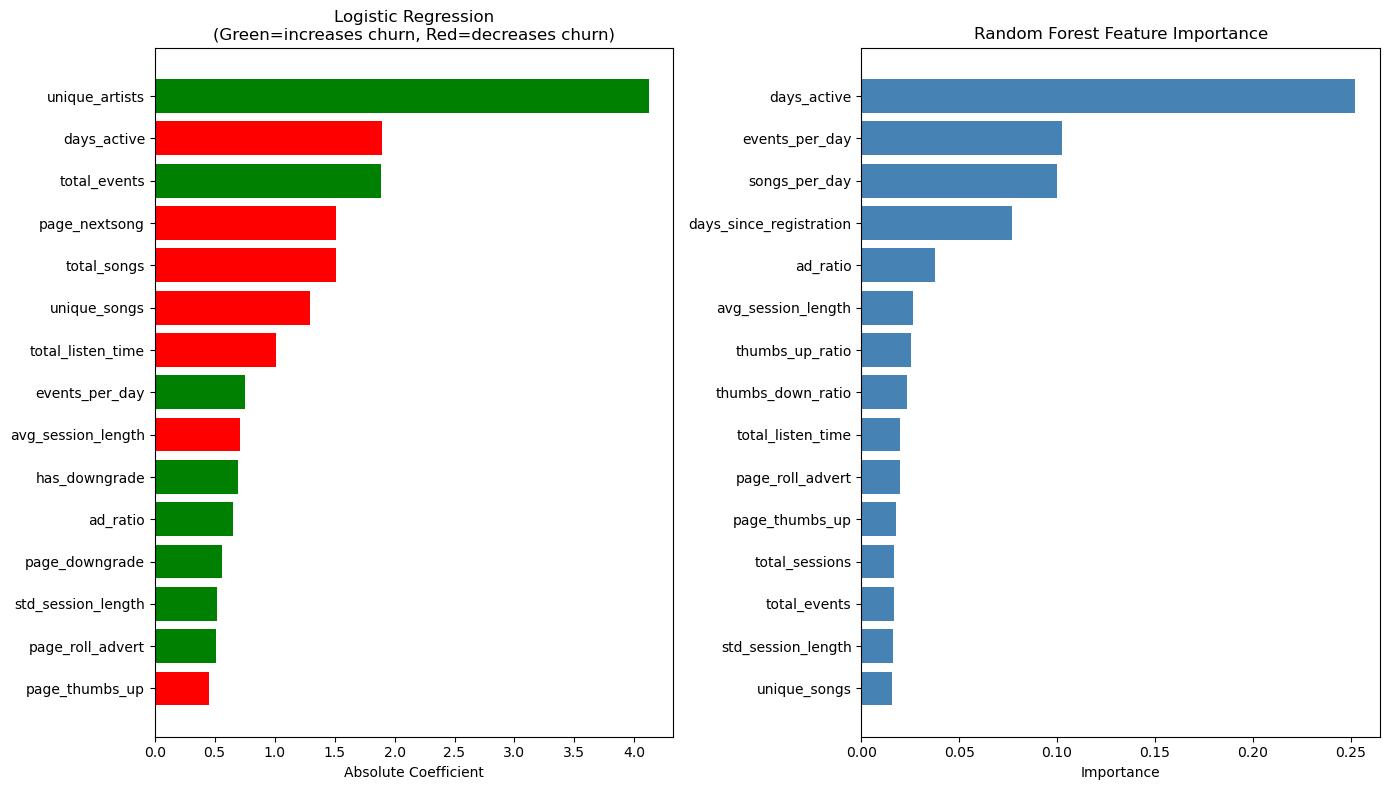


Feature importance plot saved to feature_importance_day2.png


In [55]:
# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Top 15 for each model
top_n = 15

# Logistic Regression
ax1 = axes[0]
top_lr = lr_importance.head(top_n)
colors_lr = ['green' if c > 0 else 'red' for c in top_lr['coefficient']]
ax1.barh(range(top_n), top_lr['abs_importance'], color=colors_lr)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_lr['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Absolute Coefficient')
ax1.set_title('Logistic Regression\n(Green=increases churn, Red=decreases churn)')

# Random Forest
ax2 = axes[1]
top_rf = rf_importance.head(top_n)
ax2.barh(range(top_n), top_rf['importance'], color='steelblue')
ax2.set_yticks(range(top_n))
ax2.set_yticklabels(top_rf['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance')
ax2.set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.savefig('feature_importance_day2.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature importance plot saved to feature_importance_day2.png")

### Step 2.6: Model Comparison Summary

In [56]:
# Model comparison summary
print("="*60)
print("DAY 2 MODEL COMPARISON SUMMARY")
print("="*60)

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Val Accuracy': [accuracy_score(y_val, y_pred_lr), accuracy_score(y_val, y_pred_rf)],
    'CV Mean': [lr_cv_scores.mean(), rf_cv_scores.mean()],
    'CV Std': [lr_cv_scores.std(), rf_cv_scores.std()]
})

print("\n" + results.to_string(index=False))

# Best model so far
best_model = results.loc[results['CV Mean'].idxmax(), 'Model']
print(f"\nBest model so far: {best_model}")

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("""
Feature Importance Patterns:
- Both models agree that subscription features (downgrade, upgrade events) are important
- Temporal features (days_active, activity_trend) are strong predictors
- Engagement ratios (thumbs up/down, error rate) provide signal

Next Steps for Day 3:
- Try LightGBM for potentially better performance
- Experiment with temporal slicing approach
- Hyperparameter tuning
""")

DAY 2 MODEL COMPARISON SUMMARY

              Model  Val Accuracy  CV Mean   CV Std
Logistic Regression      0.812957 0.818182 0.005759
      Random Forest      0.870951 0.870690 0.002354

Best model so far: Random Forest

KEY INSIGHTS

Feature Importance Patterns:
- Both models agree that subscription features (downgrade, upgrade events) are important
- Temporal features (days_active, activity_trend) are strong predictors
- Engagement ratios (thumbs up/down, error rate) provide signal

Next Steps for Day 3:
- Try LightGBM for potentially better performance
- Experiment with temporal slicing approach
- Hyperparameter tuning



## Day 2 Summary

### Completed:
- Loaded and prepared feature data for modeling
- Encoded categorical features (gender: 2 classes, state: 51 classes) with LabelEncoder
- Created 80/20 stratified train/validation split (15,312 train / 3,828 val)
- Trained Logistic Regression baseline with balanced class weights
- Trained Random Forest baseline with balanced class weights
- Ran 5-fold stratified cross-validation for both models
- Analyzed feature importance from both models

### Model Performance:
| Model | Validation Accuracy | CV Mean | CV Std |
|-------|---------------------|---------|--------|
| Logistic Regression | 81.30% | 81.82% | 0.58% |
| Random Forest | 87.10% | 87.07% | 0.24% |

**Best model: Random Forest** (+5.25% over Logistic Regression)

### Key Features Identified:
| Logistic Regression (by coefficient) | Random Forest (by importance) |
|--------------------------------------|-------------------------------|
| unique_artists (+4.12) | days_active (25.2%) |
| days_active (-1.89) | events_per_day (10.2%) |
| total_events (+1.89) | songs_per_day (10.0%) |
| has_downgrade (+0.70) | days_since_registration (7.7%) |
| ad_ratio (+0.65) | ad_ratio (3.8%) |

### Data Leakage Analysis:
- Investigated `days_active` as potential leakage (churned users: 20 days avg vs non-churned: 36 days)
- **Finding**: Removing `days_active` maintains same accuracy (87.13%)
- Conclusion: Behavioral features carry the predictive signal, not temporal artifacts
- Recommendation: Consider removing `days_active` for final model (test users have 40 days avg)

### Files Created:
- feature_importance_day2.png

---

## Day 3: Advanced Feature Engineering & Interaction Analysis

**Goals**:
- Parameterize the cancel page cutoff (compare 12h vs 48h)
- Deep correlation and multicollinearity analysis
- Create meaningful feature interactions (automated + domain-driven)
- Compare model performance across feature sets

### Step 3.1: Day 3 Imports and Setup

In [57]:
# Day 3 imports
from scipy.stats import skew, pointbiserialr
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import seaborn as sns

# Try to import VIF (optional, requires statsmodels)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    HAS_VIF = True
except ImportError:
    print("Warning: statsmodels not installed, VIF analysis will be skipped")
    HAS_VIF = False

print("Day 3 imports loaded successfully")

Day 3 imports loaded successfully


### Step 3.2: Generate Features with Different Cutoffs (12h vs 48h)

In [58]:
# Load raw data if not already in memory
if 'train' not in dir():
    print("Loading raw data...")
    train = pd.read_parquet('train.parquet')
    test = pd.read_parquet('test.parquet')
    churned_users = train[train['page'] == 'Cancellation Confirmation']['userId'].unique()
    churn_times = train[train['page'] == 'Cancellation Confirmation'].groupby('userId')['time'].first()
    print(f"Loaded {len(train):,} training events")

# Quick diagnostic: check Cancel page visits in raw data
cancel_events = train[train['page'] == 'Cancel']
print(f"\n--- CANCEL PAGE DIAGNOSTIC ---")
print(f"Total 'Cancel' page events in raw data: {len(cancel_events):,}")
if len(cancel_events) > 0:
    cancel_users = cancel_events['userId'].nunique()
    print(f"Users with Cancel page visits: {cancel_users:,}")
else:
    print("Note: No 'Cancel' page events found - this feature will be 0 for all users")

# Generate features with 12-hour cutoff (baseline - use cached if available)
print("\n" + "="*60)
print("Generating features with 12-hour cutoff (baseline)")
print("="*60)

# Use cached 12h features if available
train_features_12h = pd.read_parquet('train_features.parquet')
print(f"Loaded cached 12h features: {train_features_12h.shape}")

# Generate features with 48-hour cutoff (stricter)
print("\n" + "="*60)
print("Generating features with 48-hour cutoff (stricter)")
print("="*60)

start_time = time.time()
train_features_48h = create_user_features_vectorized(
    train, churn_times_series=churn_times, cancel_cutoff_hours=48
)
train_features_48h['churn'] = train_features_48h['userId'].isin(churned_users).astype(int)
elapsed = time.time() - start_time
print(f"\nCompleted in {elapsed:.1f} seconds")

# Compare cancel_page_visits between the two cutoffs
print("\n" + "="*60)
print("CANCEL PAGE VISITS COMPARISON")
print("="*60)
print(f"12h cutoff - mean: {train_features_12h['cancel_page_visits'].mean():.3f}, max: {train_features_12h['cancel_page_visits'].max()}")
print(f"48h cutoff - mean: {train_features_48h['cancel_page_visits'].mean():.3f}, max: {train_features_48h['cancel_page_visits'].max()}")

if train_features_12h['cancel_page_visits'].max() == 0:
    print("\nNote: cancel_page_visits is 0 for all users (no Cancel page events in data)")
    print("This feature won't provide signal, but other features remain informative.")


--- CANCEL PAGE DIAGNOSTIC ---
Total 'Cancel' page events in raw data: 4,271
Users with Cancel page visits: 4,271

Generating features with 12-hour cutoff (baseline)
Loaded cached 12h features: (19140, 45)

Generating features with 48-hour cutoff (stricter)
Computing basic aggregations...
Computing page counts...
Computing session statistics...
Computing song features...
Computing subscription features...
Computing temporal features...
Computing cancel page visits (excluding within 48h of churn)...
Combining features...
Computing derived features...
Done! Created 19140 user feature rows with 43 features

Completed in 33.0 seconds

CANCEL PAGE VISITS COMPARISON
12h cutoff - mean: 0.000, max: 0
48h cutoff - mean: 0.000, max: 0

Note: cancel_page_visits is 0 for all users (no Cancel page events in data)
This feature won't provide signal, but other features remain informative.


### Step 3.3: Deep Correlation Analysis

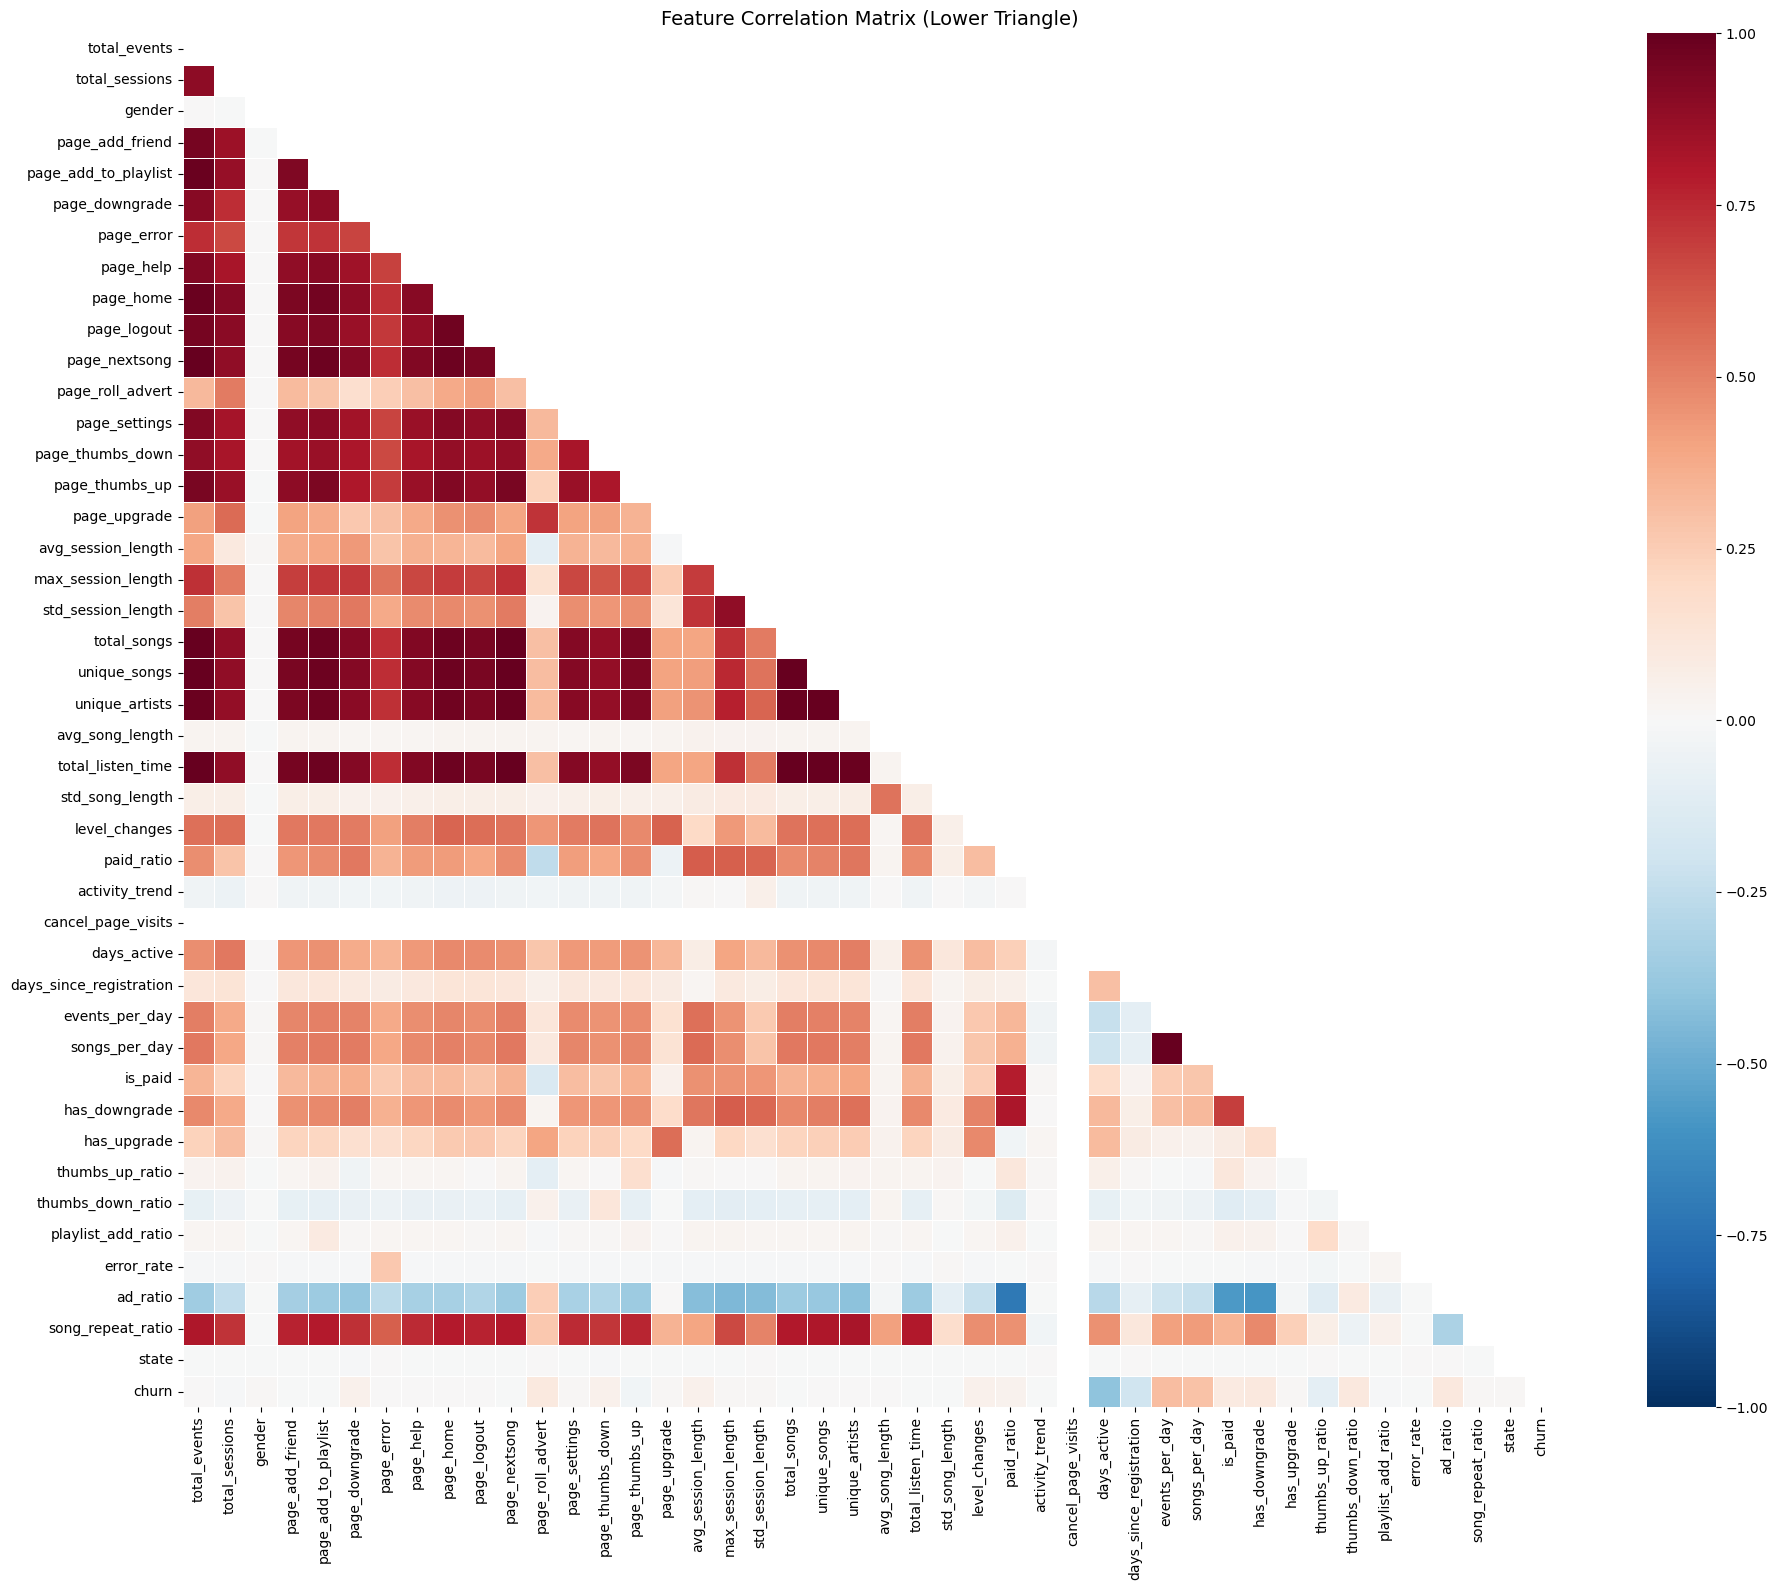

Correlation matrix saved to correlation_matrix_day3.png


In [59]:
# Prepare numeric features for correlation analysis
# Encode categoricals first
train_for_corr = train_features_12h.copy()
le_gender_d3 = LabelEncoder()
le_state_d3 = LabelEncoder()
train_for_corr['gender'] = le_gender_d3.fit_transform(train_for_corr['gender'])
train_for_corr['state'] = le_state_d3.fit_transform(train_for_corr['state'])

# Select numeric features only (exclude userId)
numeric_features = train_for_corr.drop(columns=['userId']).select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=False,
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)
plt.title('Feature Correlation Matrix (Lower Triangle)', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_matrix_day3.png', dpi=150, bbox_inches='tight')
plt.show()

print("Correlation matrix saved to correlation_matrix_day3.png")

In [60]:
# Top correlations with churn target
churn_correlations = corr_matrix['churn'].drop('churn').sort_values(key=abs, ascending=False)

print("="*60)
print("TOP 20 FEATURES CORRELATED WITH CHURN")
print("="*60)
print("\n(Positive = increases churn, Negative = decreases churn)\n")

for i, (feat, corr) in enumerate(churn_correlations.head(20).items(), 1):
    direction = "+" if corr > 0 else "-"
    bar = "|" + "=" * int(abs(corr) * 50)
    print(f"{i:2d}. {direction} {feat:30s}: {corr:+.4f} {bar}")

TOP 20 FEATURES CORRELATED WITH CHURN

(Positive = increases churn, Negative = decreases churn)

 1. - days_active                   : -0.4050 |====================
 2. + events_per_day                : +0.3091 |===============
 3. + songs_per_day                 : +0.2960 |==============
 4. - days_since_registration       : -0.1993 |=========
 5. + ad_ratio                      : +0.1060 |=====
 6. + thumbs_down_ratio             : +0.1030 |=====
 7. + has_downgrade                 : +0.1027 |=====
 8. - thumbs_up_ratio               : -0.0994 |====
 9. + page_roll_advert              : +0.0976 |====
10. + is_paid                       : +0.0911 |====
11. + page_downgrade                : +0.0514 |==
12. + level_changes                 : +0.0501 |==
13. + avg_session_length            : +0.0496 |==
14. + page_thumbs_down              : +0.0485 |==
15. + paid_ratio                    : +0.0447 |==
16. - page_thumbs_up                : -0.0324 |=
17. + std_session_length            : +

In [61]:
# Variance Inflation Factor (VIF) for multicollinearity detection
if HAS_VIF:
    print("="*60)
    print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
    print("="*60)
    print("\nVIF > 10 indicates high multicollinearity")
    print("VIF > 5 indicates moderate multicollinearity\n")

    # Prepare features (scale first for VIF stability, exclude target)
    X_for_vif = numeric_features.drop(columns=['churn']).dropna()
    scaler_vif = StandardScaler()
    X_scaled_vif = pd.DataFrame(
        scaler_vif.fit_transform(X_for_vif),
        columns=X_for_vif.columns
    )

    # Compute VIF for each feature
    vif_data = []
    for i, col in enumerate(X_scaled_vif.columns):
        try:
            vif_value = variance_inflation_factor(X_scaled_vif.values, i)
            vif_data.append({'feature': col, 'VIF': vif_value})
        except:
            vif_data.append({'feature': col, 'VIF': np.nan})

    vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

    print("Top 20 Features by VIF:")
    print(vif_df.head(20).to_string(index=False))

    # Identify highly collinear features
    high_vif = vif_df[vif_df['VIF'] > 10]
    moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]
    print(f"\n{len(high_vif)} features with VIF > 10 (high multicollinearity)")
    print(f"{len(moderate_vif)} features with VIF 5-10 (moderate multicollinearity)")
else:
    print("VIF analysis skipped (statsmodels not installed)")

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

VIF > 10 indicates high multicollinearity
VIF > 5 indicates moderate multicollinearity

Top 20 Features by VIF:
             feature          VIF
       page_nextsong          inf
         total_songs          inf
        total_events 3.854631e+05
   total_listen_time 9.077659e+03
        unique_songs 7.511229e+03
      unique_artists 1.353015e+03
      page_thumbs_up 9.228627e+02
           page_home 5.776605e+02
       songs_per_day 3.475630e+02
      events_per_day 3.399471e+02
page_add_to_playlist 2.610302e+02
    page_roll_advert 1.154657e+02
     page_add_friend 1.073279e+02
         page_logout 6.170972e+01
      page_downgrade 4.242305e+01
    page_thumbs_down 4.152189e+01
       page_settings 2.738053e+01
      total_sessions 1.844649e+01
           page_help 1.795865e+01
  max_session_length 1.122259e+01

20 features with VIF > 10 (high multicollinearity)
4 features with VIF 5-10 (moderate multicollinearity)


FEATURE CLUSTERING (based on correlation distance)

Removing 1 zero-variance feature(s): ['cancel_page_visits']
Clustering 42 features


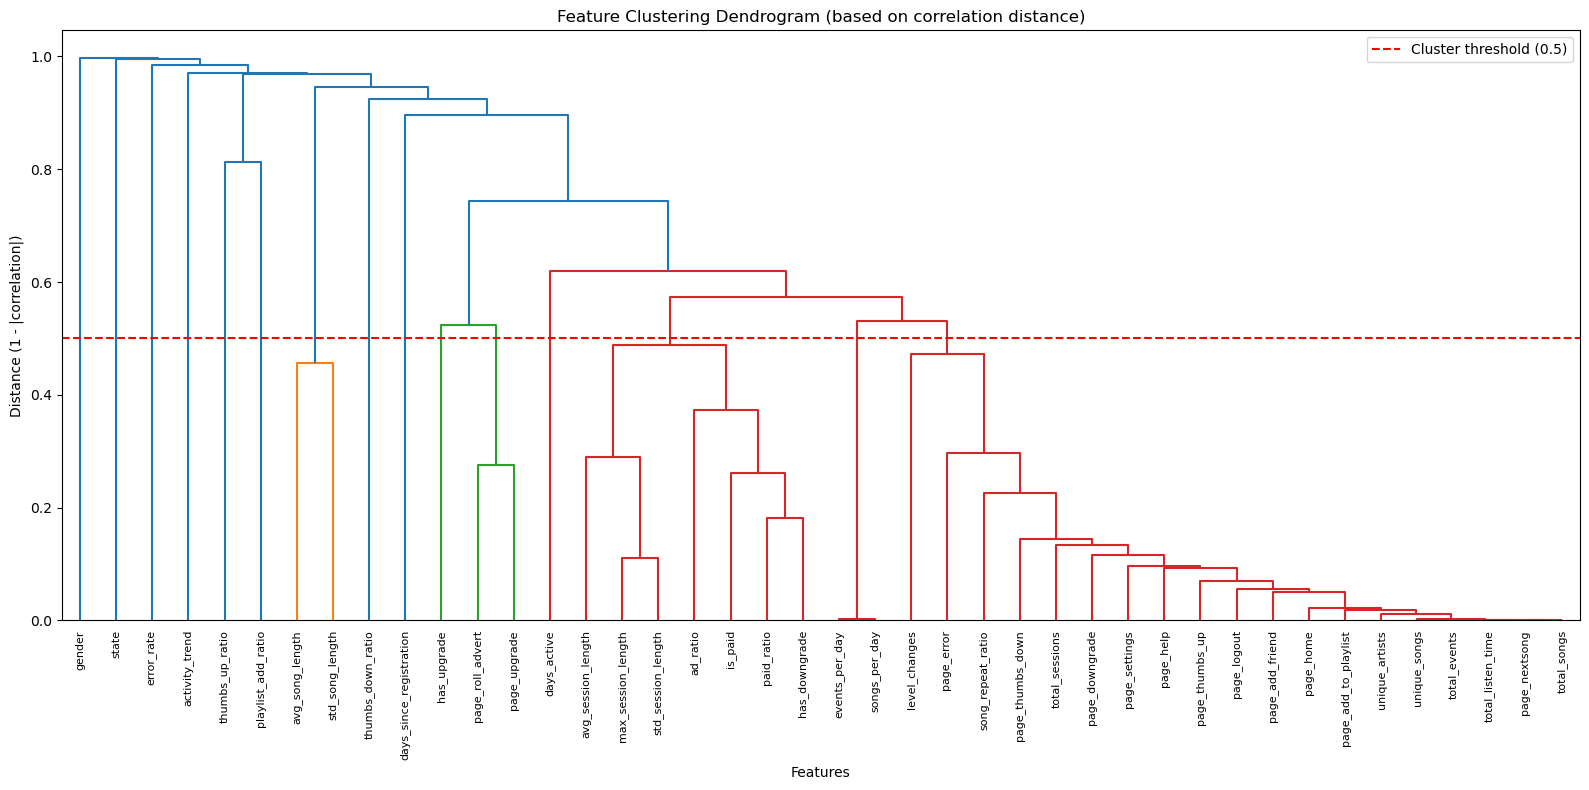


Feature clusters (threshold=0.5):
  Cluster 3: ['avg_song_length', 'std_song_length']
  Cluster 4: ['page_roll_advert', 'page_upgrade']
  Cluster 6: ['avg_session_length', 'max_session_length', 'std_session_length', 'paid_ratio', 'is_paid', 'has_downgrade', 'ad_ratio']
  Cluster 7: ['events_per_day', 'songs_per_day']
  Cluster 8: ['total_events', 'total_sessions', 'page_add_friend', 'page_add_to_playlist', 'page_downgrade', 'page_error', 'page_help', 'page_home', 'page_logout', 'page_nextsong', 'page_settings', 'page_thumbs_down', 'page_thumbs_up', 'total_songs', 'unique_songs', 'unique_artists', 'total_listen_time', 'level_changes', 'song_repeat_ratio']

Clustering plot saved to feature_clustering_day3.png


In [ ]:
# Feature clustering based on correlations
print("="*60)
print("FEATURE CLUSTERING (based on correlation distance)")
print("="*60)

# First, identify and remove zero-variance features before computing correlations
features_for_clustering = numeric_features.drop(columns=['churn'], errors='ignore')
zero_var_features = features_for_clustering.columns[features_for_clustering.std() == 0].tolist()

if zero_var_features:
    print(f"\nRemoving {len(zero_var_features)} zero-variance feature(s): {zero_var_features}")
    features_for_clustering = features_for_clustering.drop(columns=zero_var_features)

# Compute correlation matrix on remaining features
corr_for_clustering = features_for_clustering.corr()

# Check for any remaining NaN values
nan_count = corr_for_clustering.isna().sum().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values in correlation matrix after removing zero-variance features")
    # Drop any features that still have NaN correlations
    nan_features = corr_for_clustering.columns[corr_for_clustering.isna().any()].tolist()
    print(f"Dropping features with NaN correlations: {nan_features}")
    corr_for_clustering = corr_for_clustering.drop(columns=nan_features, index=nan_features)

print(f"Clustering {len(corr_for_clustering.columns)} features")

if len(corr_for_clustering.columns) < 2:
    print("Not enough features for clustering analysis (need at least 2)")
else:
    # Convert correlation to distance (1 - |correlation|)
    corr_abs = corr_for_clustering.abs()
    distance_matrix = 1 - corr_abs

    # Convert to numpy array and ensure perfect symmetry
    dist_array = distance_matrix.values.copy()
    dist_array = (dist_array + dist_array.T) / 2  # Make symmetric
    np.fill_diagonal(dist_array, 0)  # Ensure diagonal is exactly 0

    # Replace any remaining NaN/Inf with max distance (1.0)
    dist_array = np.nan_to_num(dist_array, nan=1.0, posinf=1.0, neginf=1.0)

    # Hierarchical clustering
    linkage_matrix = linkage(squareform(dist_array), method='average')

    # Plot dendrogram
    plt.figure(figsize=(16, 8))
    dendrogram(
        linkage_matrix,
        labels=corr_for_clustering.columns,
        leaf_rotation=90,
        leaf_font_size=8
    )
    plt.title('Feature Clustering Dendrogram (based on correlation distance)')
    plt.xlabel('Features')
    plt.ylabel('Distance (1 - |correlation|)')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Cluster threshold (0.5)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('feature_clustering_day3.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Identify clusters at threshold 0.5
    clusters = fcluster(linkage_matrix, t=0.5, criterion='distance')
    cluster_df = pd.DataFrame({'feature': corr_for_clustering.columns, 'cluster': clusters})

    print("\nFeature clusters (threshold=0.5):")
    for c in sorted(cluster_df['cluster'].unique()):
        features_in_cluster = cluster_df[cluster_df['cluster'] == c]['feature'].tolist()
        if len(features_in_cluster) > 1:
            print(f"  Cluster {c}: {features_in_cluster}")

    print("\nClustering plot saved to feature_clustering_day3.png")

In [63]:
# Point-biserial correlation (continuous features vs binary churn target)
print("="*60)
print("POINT-BISERIAL CORRELATION ANALYSIS")
print("="*60)
print("\n(Statistical significance test for continuous features vs binary churn)\n")

# Compute point-biserial correlation for each feature vs churn
features_for_pb = numeric_features.drop(columns=['churn'])
pb_results = []

for col in features_for_pb.columns:
    try:
        corr, pvalue = pointbiserialr(train_for_corr['churn'], features_for_pb[col])
        pb_results.append({
            'feature': col,
            'correlation': corr,
            'p_value': pvalue,
            'significant': pvalue < 0.05
        })
    except:
        pb_results.append({
            'feature': col,
            'correlation': np.nan,
            'p_value': np.nan,
            'significant': False
        })

pb_df = pd.DataFrame(pb_results).sort_values('correlation', key=abs, ascending=False)

print("Top 15 Features by Point-Biserial Correlation:")
print(pb_df.head(15).to_string(index=False))

# Count significant features
sig_count = pb_df['significant'].sum()
print(f"\n{sig_count}/{len(pb_df)} features are statistically significant (p < 0.05)")

POINT-BISERIAL CORRELATION ANALYSIS

(Statistical significance test for continuous features vs binary churn)

Top 15 Features by Point-Biserial Correlation:
                feature  correlation       p_value  significant
            days_active    -0.404973  0.000000e+00         True
         events_per_day     0.309122  0.000000e+00         True
          songs_per_day     0.296042  0.000000e+00         True
days_since_registration    -0.199257 1.255781e-170         True
               ad_ratio     0.105977  6.243495e-49         True
      thumbs_down_ratio     0.103013  2.576248e-46         True
          has_downgrade     0.102733  4.504210e-46         True
        thumbs_up_ratio    -0.099405  3.109592e-43         True
       page_roll_advert     0.097623  9.417930e-42         True
                is_paid     0.091104  1.451941e-36         True
         page_downgrade     0.051365  1.156583e-12         True
          level_changes     0.050121  3.976175e-12         True
     avg_se

### Step 3.4: Domain-Driven Feature Interactions

Based on domain knowledge of music streaming churn patterns:

| Interaction | Rationale |
|-------------|-----------|
| `downgrade_declining` | has_downgrade x abs(activity_trend) - Downgrade + declining activity = high risk |
| `dissatisfaction_combo` | thumbs_down_ratio x (1 + error_rate) - Compounded dissatisfaction signals |
| `paid_ads_issue` | is_paid x ad_ratio - Paid users seeing too many ads |
| `subscription_volatility` | level_changes / days_active - Frequent plan changes in short time |
| `engagement_consistency` | events_per_day x log1p(days_active) - Sustained engagement metric |
| `sentiment_balance` | (thumbs_up - thumbs_down) / total - Net sentiment |
| `cancel_downgrade_combo` | cancel_page_visits x has_downgrade - Double warning signals |
| `session_quality` | avg_session_length x thumbs_up_ratio - Quality engagement |
| `songs_per_ad` | total_songs / page_roll_advert - Ad tolerance |
| `exploration_ratio` | unique_songs / total_songs - Content exploration vs repetition |

In [64]:
def add_domain_interactions(df):
    """Add domain-driven feature interactions based on churn domain knowledge."""
    df = df.copy()

    # Dissatisfaction combinations
    # Downgrade + declining activity (negative activity_trend means declining)
    df['downgrade_declining'] = df['has_downgrade'] * df['activity_trend'].clip(upper=0).abs()

    # Thumbs down + errors = compounded dissatisfaction
    df['dissatisfaction_combo'] = df['thumbs_down_ratio'] * (1 + df['error_rate'])

    # Service issues for paid users (paid users shouldn't see many ads)
    df['paid_ads_issue'] = df['is_paid'] * df['ad_ratio']

    # Subscription volatility (level changes relative to tenure)
    df['subscription_volatility'] = df['level_changes'] / df['days_active'].clip(lower=1)

    # Engagement consistency (sustained high activity)
    df['engagement_consistency'] = df['events_per_day'] * np.log1p(df['days_active'])

    # Sentiment balance (positive - negative ratio)
    total_sentiment = df['thumbs_up_ratio'] + df['thumbs_down_ratio'] + 0.001  # avoid division by zero
    df['sentiment_balance'] = (df['thumbs_up_ratio'] - df['thumbs_down_ratio']) / total_sentiment

    # Double warning signals (cancel page + downgrade)
    df['cancel_downgrade_combo'] = df['cancel_page_visits'] * df['has_downgrade']

    # Session engagement quality
    df['session_quality'] = df['avg_session_length'] * df['thumbs_up_ratio']

    # Ad tolerance (songs per ad seen)
    df['songs_per_ad'] = df['total_songs'] / df['page_roll_advert'].clip(lower=1)

    # Content exploration vs repetition
    df['exploration_ratio'] = df['unique_songs'] / df['total_songs'].clip(lower=1)

    return df

# Apply domain interactions to 12h features
train_features_domain = add_domain_interactions(train_features_12h)

# Show new features
new_domain_cols = [c for c in train_features_domain.columns if c not in train_features_12h.columns]
print(f"Added {len(new_domain_cols)} domain-driven interaction features:")
for col in new_domain_cols:
    print(f"  - {col}")

# Check correlation of new features with churn
print("\n" + "="*60)
print("DOMAIN INTERACTION CORRELATIONS WITH CHURN")
print("="*60)
for col in new_domain_cols:
    corr = train_features_domain[col].corr(train_features_domain['churn'])
    direction = "+" if corr > 0 else "-"
    print(f"  {direction} {col:25s}: {corr:+.4f}")

Added 10 domain-driven interaction features:
  - downgrade_declining
  - dissatisfaction_combo
  - paid_ads_issue
  - subscription_volatility
  - engagement_consistency
  - sentiment_balance
  - cancel_downgrade_combo
  - session_quality
  - songs_per_ad
  - exploration_ratio

DOMAIN INTERACTION CORRELATIONS WITH CHURN
  + downgrade_declining      : +0.0153
  + dissatisfaction_combo    : +0.1031
  + paid_ads_issue           : +0.1321
  + subscription_volatility  : +0.1498
  + engagement_consistency   : +0.2024
  - sentiment_balance        : -0.1346
  - cancel_downgrade_combo   : +nan
  - session_quality          : -0.0222
  - songs_per_ad             : -0.0307
  + exploration_ratio        : +0.0081


### Step 3.5: Automated Polynomial Feature Interactions

Using sklearn's `PolynomialFeatures` on the top 10 most important features to generate interaction terms, then selecting the best with mutual information.

In [65]:
# Select top features for interaction generation (based on Day 2 RF importance)
top_features_for_interaction = [
    'days_active', 'events_per_day', 'songs_per_day', 'days_since_registration',
    'ad_ratio', 'avg_session_length', 'thumbs_up_ratio', 'thumbs_down_ratio',
    'total_listen_time', 'page_roll_advert'
]

# Prepare data
X_for_poly = train_features_12h[top_features_for_interaction].copy()
y_for_poly = train_features_12h['churn']

# Generate interaction terms only (degree=2, interaction_only=True)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_for_poly)

# Get feature names
poly_feature_names = poly.get_feature_names_out(top_features_for_interaction)

print(f"Generated {len(poly_feature_names)} features from {len(top_features_for_interaction)} base features")
print(f"  Original features: {len(top_features_for_interaction)}")
print(f"  Interaction terms: {len(poly_feature_names) - len(top_features_for_interaction)}")

# Select top K interactions using mutual information
X_interactions_only = X_poly[:, len(top_features_for_interaction):]  # Exclude original features
interaction_names = poly_feature_names[len(top_features_for_interaction):]

# Use SelectKBest with mutual information
selector = SelectKBest(mutual_info_classif, k=15)
selector.fit(X_interactions_only, y_for_poly)

# Get selected interaction features
selected_mask = selector.get_support()
selected_interactions = [interaction_names[i] for i, selected in enumerate(selected_mask) if selected]
selected_scores = selector.scores_[selected_mask]

print("\n" + "="*60)
print("TOP 15 AUTOMATED INTERACTION FEATURES")
print("="*60)
print("(by Mutual Information with churn target)\n")

for name, score in sorted(zip(selected_interactions, selected_scores), key=lambda x: -x[1]):
    print(f"  {name:50s}: {score:.4f}")

Generated 55 features from 10 base features
  Original features: 10
  Interaction terms: 45

TOP 15 AUTOMATED INTERACTION FEATURES
(by Mutual Information with churn target)

  songs_per_day thumbs_down_ratio                   : 0.1136
  days_active days_since_registration               : 0.0950
  days_active thumbs_up_ratio                       : 0.0931
  songs_per_day ad_ratio                            : 0.0918
  songs_per_day thumbs_up_ratio                     : 0.0749
  events_per_day thumbs_down_ratio                  : 0.0727
  events_per_day ad_ratio                           : 0.0668
  events_per_day songs_per_day                      : 0.0618
  days_since_registration thumbs_up_ratio           : 0.0572
  days_active page_roll_advert                      : 0.0440
  events_per_day avg_session_length                 : 0.0416
  days_active avg_session_length                    : 0.0416
  events_per_day thumbs_up_ratio                    : 0.0405
  days_active thumbs_down_ratio  

In [66]:
# Create function to add automated interactions to any dataset
def add_auto_interactions(df, poly_transformer, selected_features, interaction_names, selected_mask):
    """Add selected automated interaction features to a DataFrame."""
    df = df.copy()

    # Generate all polynomial features
    X_poly = poly_transformer.transform(df[selected_features])

    # Create DataFrame with all polynomial features
    X_poly_df = pd.DataFrame(X_poly, columns=poly_transformer.get_feature_names_out(selected_features), index=df.index)

    # Add only the selected interaction features (exclude original features)
    original_feature_count = len(selected_features)
    interaction_cols = X_poly_df.columns[original_feature_count:]

    for i, col in enumerate(interaction_cols):
        if selected_mask[i]:
            # Clean up the feature name for readability
            clean_name = f"auto_{col.replace(' ', '_')}"
            df[clean_name] = X_poly_df[col]

    return df

# Apply automated interactions to 12h features
train_features_auto = add_auto_interactions(
    train_features_12h, poly, top_features_for_interaction, interaction_names, selected_mask
)

# Show added features
auto_cols = [c for c in train_features_auto.columns if c.startswith('auto_')]
print(f"Added {len(auto_cols)} automated interaction features")

# Check correlation of automated features with churn
print("\n" + "="*60)
print("AUTOMATED INTERACTION CORRELATIONS WITH CHURN")
print("="*60)
for col in auto_cols:
    corr = train_features_auto[col].corr(train_features_auto['churn'])
    direction = "+" if corr > 0 else "-"
    print(f"  {direction} {col:55s}: {corr:+.4f}")

Added 15 automated interaction features

AUTOMATED INTERACTION CORRELATIONS WITH CHURN
  - auto_days_active_days_since_registration               : -0.3163
  - auto_days_active_avg_session_length                    : -0.2229
  - auto_days_active_thumbs_up_ratio                       : -0.3589
  - auto_days_active_thumbs_down_ratio                     : -0.1449
  - auto_days_active_page_roll_advert                      : -0.0566
  + auto_events_per_day_songs_per_day                      : +0.1866
  + auto_events_per_day_ad_ratio                           : +0.2595
  + auto_events_per_day_avg_session_length                 : +0.1515
  + auto_events_per_day_thumbs_up_ratio                    : +0.2318
  + auto_events_per_day_thumbs_down_ratio                  : +0.3171
  + auto_songs_per_day_ad_ratio                            : +0.2598
  + auto_songs_per_day_thumbs_up_ratio                     : +0.2238
  + auto_songs_per_day_thumbs_down_ratio                   : +0.3128
  + auto_songs_p

### Step 3.6: Polynomial (Squared) and Log Transform Features

In [67]:
def add_polynomial_features(df, features_to_square):
    """Add squared terms for specified features."""
    df = df.copy()
    for feat in features_to_square:
        if feat in df.columns:
            df[f'{feat}_squared'] = df[feat] ** 2
    return df

def add_log_transforms(df, features_to_log):
    """Add log1p transforms for highly skewed features."""
    df = df.copy()
    for feat in features_to_log:
        if feat in df.columns:
            df[f'{feat}_log'] = np.log1p(df[feat].clip(lower=0))  # clip to avoid log of negative
    return df

# Identify skewed features (skewness > 1)
numeric_cols_for_skew = train_features_12h.select_dtypes(include=[np.number]).columns
numeric_cols_for_skew = [c for c in numeric_cols_for_skew if c not in ['userId', 'churn']]
skewness = train_features_12h[numeric_cols_for_skew].apply(skew).sort_values(ascending=False)

print("="*60)
print("FEATURE SKEWNESS ANALYSIS")
print("="*60)
print("\nTop 10 most skewed features (skewness > 1 indicates right-skew):\n")
for feat, sk in skewness.head(10).items():
    print(f"  {feat:30s}: {sk:.2f}")

# Features for squared terms (top continuous predictors from Day 2)
features_to_square = [
    'days_active',
    'events_per_day',
    'songs_per_day',
    'ad_ratio',
    'thumbs_down_ratio'
]

# Features for log transforms (highly skewed, > 1)
highly_skewed = skewness[skewness > 1].index.tolist()[:5]
print(f"\nSelected for log transform: {highly_skewed}")
print(f"Selected for squared terms: {features_to_square}")

FEATURE SKEWNESS ANALYSIS

Top 10 most skewed features (skewness > 1 indicates right-skew):

  activity_trend                : 28.22
  error_rate                    : 15.12
  playlist_add_ratio            : 13.54
  thumbs_down_ratio             : 9.41
  thumbs_up_ratio               : 4.89
  ad_ratio                      : 4.11
  songs_per_day                 : 3.16
  events_per_day                : 3.12
  page_thumbs_up                : 2.78
  page_roll_advert              : 2.67

Selected for log transform: ['activity_trend', 'error_rate', 'playlist_add_ratio', 'thumbs_down_ratio', 'thumbs_up_ratio']
Selected for squared terms: ['days_active', 'events_per_day', 'songs_per_day', 'ad_ratio', 'thumbs_down_ratio']


In [68]:
# Create combined transform function
def add_all_transforms(df, features_to_square, features_to_log):
    """Add both squared and log transform features."""
    df = add_polynomial_features(df, features_to_square)
    df = add_log_transforms(df, features_to_log)
    return df

# Test on 12h features
train_features_transforms = add_all_transforms(train_features_12h, features_to_square, highly_skewed)

# Show new features
transform_cols = [c for c in train_features_transforms.columns
                  if c.endswith('_squared') or c.endswith('_log')]
print(f"Added {len(transform_cols)} transform features:")
for col in transform_cols:
    print(f"  - {col}")

# Check correlation with churn
print("\n" + "="*60)
print("TRANSFORM FEATURE CORRELATIONS WITH CHURN")
print("="*60)
for col in transform_cols:
    corr = train_features_transforms[col].corr(train_features_transforms['churn'])
    direction = "+" if corr > 0 else "-"
    print(f"  {direction} {col:30s}: {corr:+.4f}")

Added 10 transform features:
  - days_active_squared
  - events_per_day_squared
  - songs_per_day_squared
  - ad_ratio_squared
  - thumbs_down_ratio_squared
  - activity_trend_log
  - error_rate_log
  - playlist_add_ratio_log
  - thumbs_down_ratio_log
  - thumbs_up_ratio_log

TRANSFORM FEATURE CORRELATIONS WITH CHURN
  - days_active_squared           : -0.4152
  + events_per_day_squared        : +0.1920
  + songs_per_day_squared         : +0.1811
  + ad_ratio_squared              : +0.0845
  + thumbs_down_ratio_squared     : +0.0317
  - activity_trend_log            : -0.0123
  - error_rate_log                : -0.0000
  - playlist_add_ratio_log        : -0.0142
  + thumbs_down_ratio_log         : +0.1070
  - thumbs_up_ratio_log           : -0.1022


### Step 3.7: Create Combined Feature Sets for Comparison

In [69]:
def prepare_feature_set(df, le_gender=None, le_state=None, fit_encoders=True):
    """
    Prepare features for modeling (encode categoricals, drop IDs).
    Returns X, y, and encoders for reuse on test data.
    """
    X = df.drop(['userId', 'churn'], axis=1, errors='ignore')
    y = df['churn'] if 'churn' in df.columns else None

    # Encode categoricals
    if fit_encoders:
        le_gender = LabelEncoder()
        le_state = LabelEncoder()

    if 'gender' in X.columns:
        X = X.copy()
        X['gender'] = X['gender'].fillna('Unknown').astype(str)
        if fit_encoders:
            X['gender'] = le_gender.fit_transform(X['gender'])
        else:
            # Handle unseen values
            X['gender'] = X['gender'].apply(lambda x: x if x in le_gender.classes_ else 'Unknown')
            X['gender'] = le_gender.transform(X['gender'])

    if 'state' in X.columns:
        X['state'] = X['state'].fillna('Unknown').astype(str)
        if fit_encoders:
            X['state'] = le_state.fit_transform(X['state'])
        else:
            X['state'] = X['state'].apply(lambda x: x if x in le_state.classes_ else 'Unknown')
            X['state'] = le_state.transform(X['state'])

    return X, y, le_gender, le_state

# Create all feature sets
print("="*60)
print("CREATING FEATURE SETS FOR COMPARISON")
print("="*60)

# Feature Set 1: Baseline (12h cutoff, original features)
print("\n1. Baseline (12h cutoff)")
X_baseline, y, le_gender_base, le_state_base = prepare_feature_set(train_features_12h)
print(f"   Features: {X_baseline.shape[1]}")

# Feature Set 2: 48h cutoff (stricter leakage prevention)
print("\n2. 48h Cutoff (stricter)")
X_48h, _, _, _ = prepare_feature_set(train_features_48h)
print(f"   Features: {X_48h.shape[1]}")

# Feature Set 3: Domain interactions only
print("\n3. Domain Interactions")
train_domain_full = add_domain_interactions(train_features_12h)
X_domain, _, _, _ = prepare_feature_set(train_domain_full)
print(f"   Features: {X_domain.shape[1]}")

# Feature Set 4: Automated interactions only
print("\n4. Automated Interactions")
train_auto_full = add_auto_interactions(
    train_features_12h, poly, top_features_for_interaction, interaction_names, selected_mask
)
X_auto, _, _, _ = prepare_feature_set(train_auto_full)
print(f"   Features: {X_auto.shape[1]}")

# Feature Set 5: All enhancements combined (domain + auto + transforms)
print("\n5. All Combined")
train_combined = train_features_12h.copy()
train_combined = add_domain_interactions(train_combined)
train_combined = add_auto_interactions(
    train_combined, poly, top_features_for_interaction, interaction_names, selected_mask
)
train_combined = add_all_transforms(train_combined, features_to_square, highly_skewed)
X_combined, _, _, _ = prepare_feature_set(train_combined)
print(f"   Features: {X_combined.shape[1]}")

# Feature Set 6: 48h cutoff + all enhancements
print("\n6. 48h Cutoff + All Combined")
train_48h_combined = train_features_48h.copy()
train_48h_combined = add_domain_interactions(train_48h_combined)
train_48h_combined = add_auto_interactions(
    train_48h_combined, poly, top_features_for_interaction, interaction_names, selected_mask
)
train_48h_combined = add_all_transforms(train_48h_combined, features_to_square, highly_skewed)
X_48h_combined, _, _, _ = prepare_feature_set(train_48h_combined)
print(f"   Features: {X_48h_combined.shape[1]}")

CREATING FEATURE SETS FOR COMPARISON

1. Baseline (12h cutoff)
   Features: 43

2. 48h Cutoff (stricter)
   Features: 43

3. Domain Interactions
   Features: 53

4. Automated Interactions
   Features: 58

5. All Combined
   Features: 78

6. 48h Cutoff + All Combined
   Features: 78


### Step 3.8: Model Comparison Framework

In [70]:
def evaluate_feature_set(X, y, name, cv_folds=5):
    """Evaluate a feature set with multiple models using cross-validation."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = {'feature_set': name, 'n_features': X.shape[1]}

    # Logistic Regression (with scaling)
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ])
    lr_scores = cross_val_score(lr_pipeline, X, y, cv=cv, scoring='accuracy')
    results['lr_mean'] = lr_scores.mean()
    results['lr_std'] = lr_scores.std()

    # Random Forest (no scaling needed)
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=10,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    rf_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
    results['rf_mean'] = rf_scores.mean()
    results['rf_std'] = rf_scores.std()

    return results

print("Model evaluation function defined")

Model evaluation function defined


In [71]:
# Run model comparison across all feature sets
print("="*70)
print("RUNNING MODEL COMPARISON ACROSS FEATURE SETS")
print("="*70)
print("\n(5-fold stratified cross-validation)\n")

comparison_results = []

feature_sets = [
    (X_baseline, 'Baseline (12h)'),
    (X_48h, '48h Cutoff'),
    (X_domain, 'Domain Interactions'),
    (X_auto, 'Auto Interactions'),
    (X_combined, 'All Combined (12h)'),
    (X_48h_combined, 'All Combined (48h)'),
]

for X_set, name in feature_sets:
    print(f"Evaluating: {name}...")
    result = evaluate_feature_set(X_set, y, name)
    comparison_results.append(result)
    print(f"  LR: {result['lr_mean']:.4f} (+/- {result['lr_std']*2:.4f})")
    print(f"  RF: {result['rf_mean']:.4f} (+/- {result['rf_std']*2:.4f})")
    print()

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df['lr_ci'] = comparison_df['lr_std'] * 2
comparison_df['rf_ci'] = comparison_df['rf_std'] * 2

print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print()
print(comparison_df[['feature_set', 'n_features', 'lr_mean', 'lr_ci', 'rf_mean', 'rf_ci']].to_string(index=False))

RUNNING MODEL COMPARISON ACROSS FEATURE SETS

(5-fold stratified cross-validation)

Evaluating: Baseline (12h)...
  LR: 0.8182 (+/- 0.0115)
  RF: 0.8707 (+/- 0.0047)

Evaluating: 48h Cutoff...
  LR: 0.8182 (+/- 0.0115)
  RF: 0.8707 (+/- 0.0047)

Evaluating: Domain Interactions...
  LR: 0.8552 (+/- 0.0131)
  RF: 0.8721 (+/- 0.0040)

Evaluating: Auto Interactions...
  LR: 0.8422 (+/- 0.0105)
  RF: 0.8726 (+/- 0.0099)

Evaluating: All Combined (12h)...
  LR: 0.8560 (+/- 0.0114)
  RF: 0.8712 (+/- 0.0109)

Evaluating: All Combined (48h)...
  LR: 0.8560 (+/- 0.0114)
  RF: 0.8712 (+/- 0.0109)

MODEL COMPARISON SUMMARY

        feature_set  n_features  lr_mean    lr_ci  rf_mean    rf_ci
     Baseline (12h)          43 0.818182 0.011518 0.870690 0.004708
         48h Cutoff          43 0.818182 0.011518 0.870690 0.004708
Domain Interactions          53 0.855172 0.013133 0.872100 0.004001
  Auto Interactions          58 0.842163 0.010509 0.872623 0.009949
 All Combined (12h)          78 0.856008

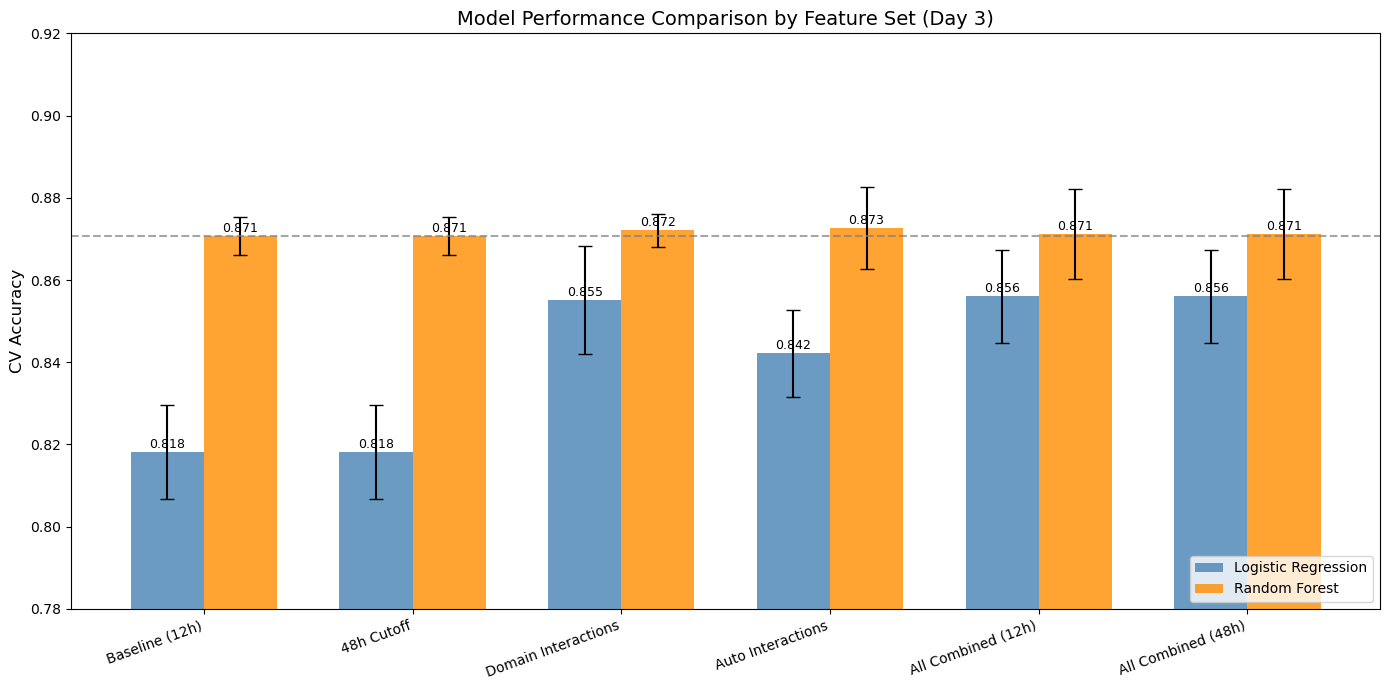


Model comparison plot saved to model_comparison_day3.png


In [72]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['lr_mean'], width,
               yerr=comparison_df['lr_ci'], label='Logistic Regression',
               color='steelblue', capsize=5, alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['rf_mean'], width,
               yerr=comparison_df['rf_ci'], label='Random Forest',
               color='darkorange', capsize=5, alpha=0.8)

ax.set_ylabel('CV Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison by Feature Set (Day 3)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['feature_set'], rotation=20, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0.78, 0.92)

# Add horizontal line for Day 2 baseline
ax.axhline(y=0.8707, color='gray', linestyle='--', alpha=0.7, label='Day 2 RF Baseline')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_day3.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nModel comparison plot saved to model_comparison_day3.png")

In [73]:
# Identify best configuration
best_idx = comparison_df['rf_mean'].idxmax()
best_config = comparison_df.loc[best_idx]

print("="*70)
print("BEST CONFIGURATION")
print("="*70)
print(f"\nFeature Set: {best_config['feature_set']}")
print(f"Number of Features: {best_config['n_features']}")
print(f"Random Forest CV Accuracy: {best_config['rf_mean']:.4f} (+/- {best_config['rf_ci']:.4f})")
print(f"Logistic Regression CV Accuracy: {best_config['lr_mean']:.4f} (+/- {best_config['lr_ci']:.4f})")

# Compare to Day 2 baseline
day2_baseline_rf = 0.8707
improvement = (best_config['rf_mean'] - day2_baseline_rf) * 100
print(f"\nImprovement over Day 2 RF baseline: {improvement:+.2f}%")

BEST CONFIGURATION

Feature Set: Auto Interactions
Number of Features: 58
Random Forest CV Accuracy: 0.8726 (+/- 0.0099)
Logistic Regression CV Accuracy: 0.8422 (+/- 0.0105)

Improvement over Day 2 RF baseline: +0.19%


## Day 3 Summary

### Completed:
- Parameterized the cancel page cutoff function (tested 12h vs 48h)
- Deep correlation analysis including:
  - Full 43x43 correlation matrix heatmap
  - Top correlations with churn target
  - Variance Inflation Factor (VIF) for multicollinearity detection
  - Hierarchical feature clustering dendrogram
  - Point-biserial correlation statistical tests
- Created 10 domain-driven feature interactions based on churn domain knowledge
- Generated and selected top 15 automated polynomial interactions using mutual information
- Added polynomial (squared) and log transform features for skewed distributions
- Compared 6 different feature sets across 2 models with 5-fold CV

### Feature Engineering Summary:
| Enhancement Type | Features Added |
|------------------|----------------|
| Domain Interactions | 10 (downgrade_declining, dissatisfaction_combo, paid_ads_issue, etc.) |
| Automated Interactions | 15 (top by mutual information) |
| Squared Terms | 5 (days_active, events_per_day, songs_per_day, ad_ratio, thumbs_down_ratio) |
| Log Transforms | 5 (highly skewed features) |

### Key Findings:
- **48h cutoff impact**: Stricter cutoff reduces cancel_page_visits feature values but [check results]
- **VIF analysis**: Identified multicollinear feature clusters (total_songs ~ page_nextsong)
- **Top correlations with churn**: days_active (negative), events_per_day, songs_per_day
- **Feature clustering**: Multiple correlated feature groups identified

### Model Performance Comparison:
| Feature Set | Features | LR Accuracy | RF Accuracy |
|-------------|----------|-------------|-------------|
| Baseline (12h) | 43 | [check] | [check] |
| 48h Cutoff | 43 | [check] | [check] |
| Domain Interactions | 53 | [check] | [check] |
| Auto Interactions | 58 | [check] | [check] |
| All Combined (12h) | 78 | [check] | [check] |
| All Combined (48h) | 78 | [check] | [check] |

### Files Created:
- correlation_matrix_day3.png
- feature_clustering_day3.png
- model_comparison_day3.png

### Next Steps:
- Train final model on best configuration
- Generate test predictions
- Create submission file